In [1]:
import os
import subprocess

# Clone the NAB repository if it doesn't exist
if not os.path.exists('NAB'):
    subprocess.run(['git', 'clone', 'https://github.com/numenta/NAB.git'])


In [2]:
import pandas as pd

# Define the path to the dataset
data_path = 'NAB/data/realKnownCause/ambient_temperature_system_failure.csv'

# Read the dataset
df = pd.read_csv(data_path, parse_dates=['timestamp'])
df.set_index('timestamp', inplace=True)

# Display the first few rows
#df.head(27)


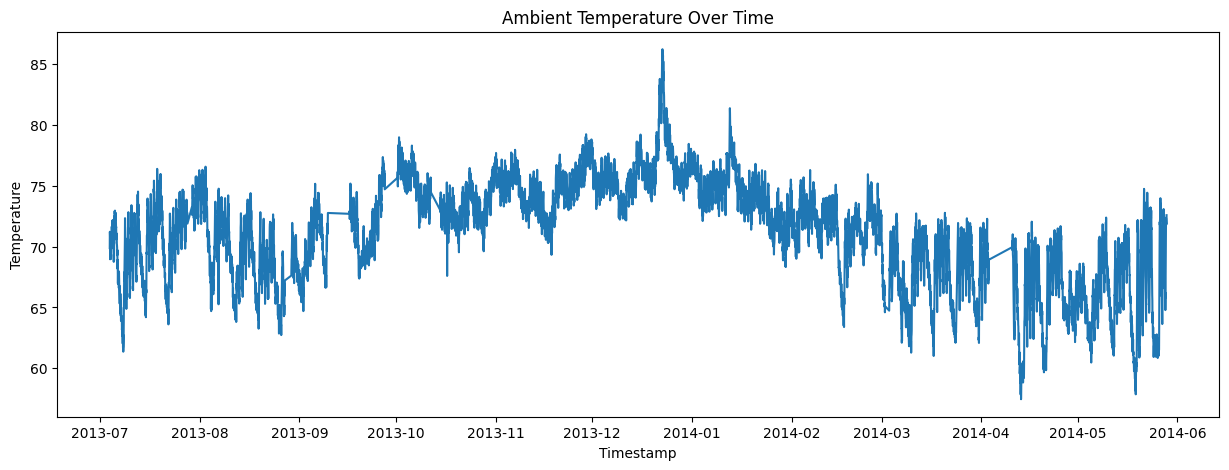

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))
plt.plot(df.index, df['value'])
plt.title('Ambient Temperature Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.show()


In [4]:
# Path to the labels file
labels_path = 'NAB/labels/combined_windows.json'

#"2013-12-15 07:00:00.000000", labes 
#"2013-12-30 09:00:00.000000"
#"2014-03-29 15:00:00.000000",
#"2014-04-20 22:00:00.000000"

import json

# Load the labels
with open(labels_path, 'r') as file:
    labels = json.load(file)   
        
# Extract anomaly windows for the selected dataset
anomaly_windows = labels['realKnownCause/ambient_temperature_system_failure.csv']
print(anomaly_windows)
#print(df)

[['2013-12-15 07:00:00.000000', '2013-12-30 09:00:00.000000'], ['2014-03-29 15:00:00.000000', '2014-04-20 22:00:00.000000']]


In [5]:
import numpy as np

# Initialize anomaly column
df['anomaly'] = 0

# Mark anomalies based on the provided windows
for window in anomaly_windows:
    start = pd.to_datetime(window[0])
    end = pd.to_datetime(window[1])
    #print(start, end)
    df.loc[start:end, 'anomaly'] = 1

# Verify the anomalies
df['anomaly'].value_counts()
#print(df.describe)

anomaly
0    6541
1     726
Name: count, dtype: int64

In [6]:
from scipy import stats

# Calculate rolling mean and std
rolling_mean = df['value'].rolling(window=24).mean()
rolling_std = df['value'].rolling(window=24).std()

# Compute Z-scores
df['z_score'] = (df['value'] - rolling_mean) / rolling_std


z_threshold = 3
df['z_anomaly'] = df['z_score'].apply(lambda x: 1 if abs(x) > z_threshold else 0)
#df.head(27)

In [7]:
from sklearn.ensemble import IsolationForest

# Since Isolation Forest expects a 2D array
X = df[['value']].values
#print(X)
# Define the model
iso_forest = IsolationForest(contamination=0.04, random_state=42)

# Fit the model
iso_forest.fit(X)

# Predict anomalies
df['if_anomaly'] = iso_forest.predict(X)
# Convert predictions: -1 for anomalies, 1 for normal -> 1 for anomalies, 0 for normal
df['if_anomaly'] = df['if_anomaly'].map({1: 0, -1: 1})


In [8]:
from sklearn.preprocessing import MinMaxScaler

# Scale the data
scaler = MinMaxScaler()
df['value_scaled'] = scaler.fit_transform(df[['value']])

# Create sequences
sequence_length = 24
def create_sequences(data, seq_length):
    xs = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        xs.append(x)
    return np.array(xs)

X_lstm = create_sequences(df['value_scaled'].values, sequence_length)
#print(X_lstm)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

# Define the model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, 1), return_sequences=False),
    RepeatVector(sequence_length),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(1))
])

model.compile(optimizer='adam', loss='mse')

# Reshape data for LSTM [samples, timesteps, features]
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

# Split into training and test sets
train_size = int(X_lstm.shape[0] * 0.8)
X_train, X_test = X_lstm[:train_size], X_lstm[train_size:]

# Train the model
history = model.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.1, shuffle=False)


Epoch 1/10
163/163 [==============================] - 8s 27ms/step - loss: 0.0273 - val_loss: 0.0055
Epoch 2/10
163/163 [==============================] - 4s 22ms/step - loss: 0.0037 - val_loss: 0.0057
Epoch 3/10
163/163 [==============================] - 4s 22ms/step - loss: 0.0026 - val_loss: 0.0050
Epoch 4/10
163/163 [==============================] - 4s 23ms/step - loss: 0.0026 - val_loss: 0.0048
Epoch 5/10
163/163 [==============================] - 4s 24ms/step - loss: 0.0026 - val_loss: 0.0047
Epoch 6/10
163/163 [==============================] - 4s 22ms/step - loss: 0.0025 - val_loss: 0.0045
Epoch 7/10
163/163 [==============================] - 4s 23ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 8/10
163/163 [==============================] - 4s 22ms/step - loss: 0.0024 - val_loss: 0.0042
Epoch 9/10
163/163 [==============================] - 4s 25ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 10/10
163/163 [==============================] - 4s 22ms/step - loss: 0.0023 - val_lo

In [10]:
# Get reconstruction loss
X_pred = model.predict(X_lstm)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1])
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1])

reconstruction_errors = np.mean(np.power(X_lstm - X_pred, 2), axis=1)

# Set a threshold for anomalies
threshold = np.percentile(reconstruction_errors, 95)

# Detect anomalies
df_anomaly = df.iloc[sequence_length:]
df_anomaly['lstm_anomaly'] = (reconstruction_errors > threshold).astype(int)


227/227 [==============================] - 2s 8ms/step


C:\Users\Win10\AppData\Local\Temp\ipykernel_16492\283663569.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anomaly['lstm_anomaly'] = (reconstruction_errors > threshold).astype(int)


In [11]:
from sklearn.neighbors import LocalOutlierFactor

# Use the same data as before
X_lof = df[['value']].values

# Define the model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)

# Fit the model and predict anomalies (LOF predicts during fitting)
y_pred_lof = lof.fit_predict(X_lof)

# Convert predictions: -1 for anomalies, 1 for normal -> 1 for anomalies, 0 for normal
df['lof_anomaly'] = [1 if x == -1 else 0 for x in y_pred_lof]
#print(df)

In [12]:
from sklearn.svm import OneClassSVM

# Use the same data as before
X_ocsvm = df[['value']].values
# Define the model
ocsvm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.01)

# Fit the model
ocsvm.fit(X_ocsvm)

# Predict anomalies
y_pred_ocsvm = ocsvm.predict(X_ocsvm)

# Convert predictions: -1 for anomalies, 1 for normal -> 1 for anomalies, 0 for normal
df['ocsvm_anomaly'] = [1 if x == -1 else 0 for x in y_pred_ocsvm]


In [13]:
from sklearn.metrics import precision_recall_fscore_support

# Initialize a DataFrame to store the results
results = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1-Score'])

def collect_metrics(df, anomaly_col, model_name):
    y_true = df['anomaly']
    y_pred = df[anomaly_col]
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    results.loc[len(results)] = [model_name, precision, recall, f1]

# Collect metrics for each model
collect_metrics(df, 'z_anomaly', 'Z-Score')
collect_metrics(df, 'if_anomaly', 'Isolation-Forest')
collect_metrics(df, 'lof_anomaly', 'Local-Outlier-Factor')
collect_metrics(df, 'ocsvm_anomaly', 'One-Class-SVM')

# For LSTM Autoencoder, use df_anomaly
precision_lstm, recall_lstm, f1_lstm, _ = precision_recall_fscore_support(df_anomaly['anomaly'], df_anomaly['lstm_anomaly'], average='binary', zero_division=0)
results.loc[len(results)] = ['LSTM-Autoencoder', precision_lstm, recall_lstm, f1_lstm]

# Display the results
print(results)


                  Model  Precision    Recall  F1-Score
0               Z-Score   0.105263  0.002755  0.005369
1      Isolation-Forest   0.522491  0.207989  0.297537
2  Local-Outlier-Factor   0.315068  0.031680  0.057572
3         One-Class-SVM   0.780822  0.078512  0.142678
4      LSTM-Autoencoder   0.168044  0.084022  0.112029


In [14]:
def plot_anomalies(df, anomaly_col, title):
    plt.figure(figsize=(15, 5))
    plt.plot(df.index, df['value'], label='Value')
    anomalies = df[df[anomaly_col] == 1]
    plt.scatter(anomalies.index, anomalies['value'], color='red', label='Anomalies')
    plt.title(title)
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


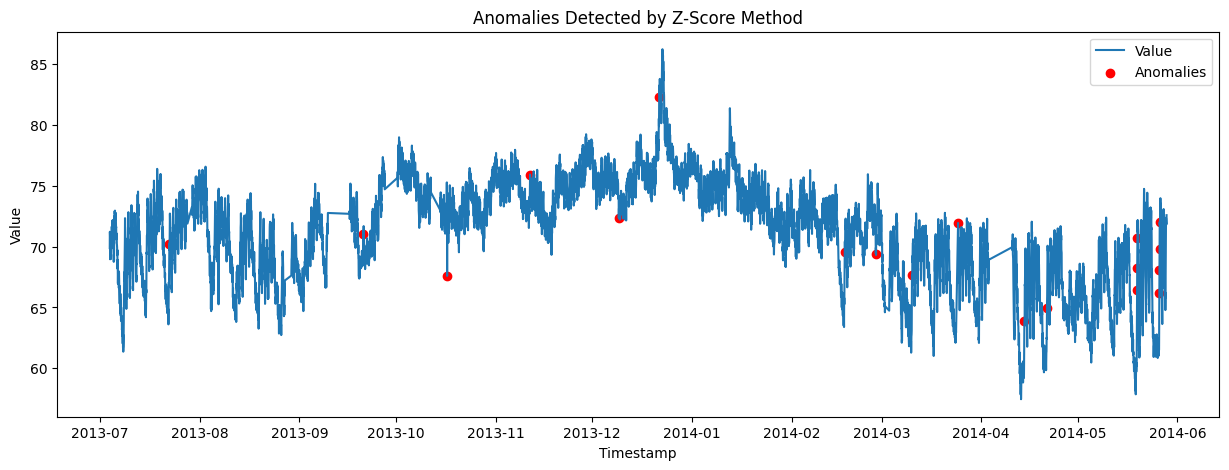

In [15]:
plot_anomalies(df, 'z_anomaly', 'Anomalies Detected by Z-Score Method')


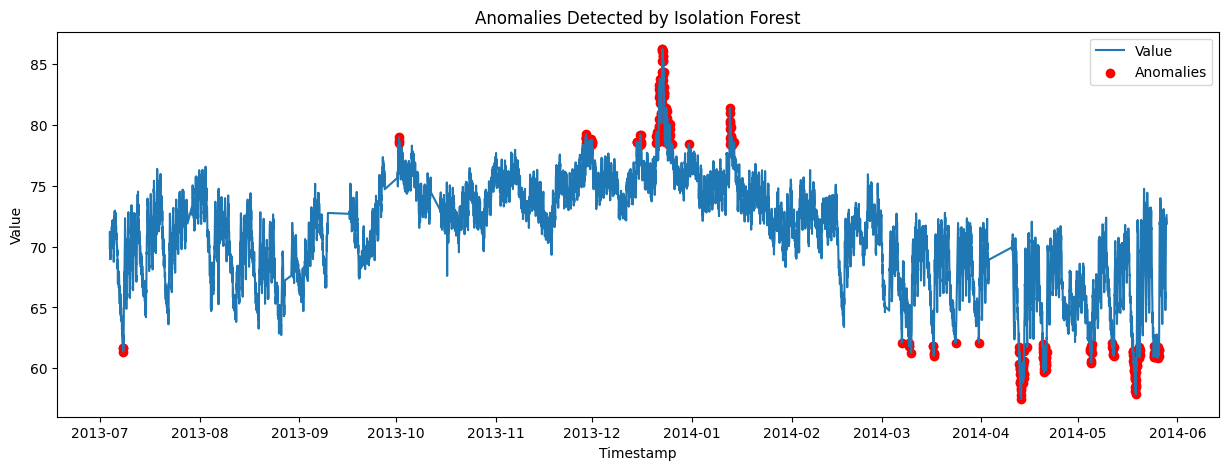

In [16]:
plot_anomalies(df, 'if_anomaly', 'Anomalies Detected by Isolation Forest')


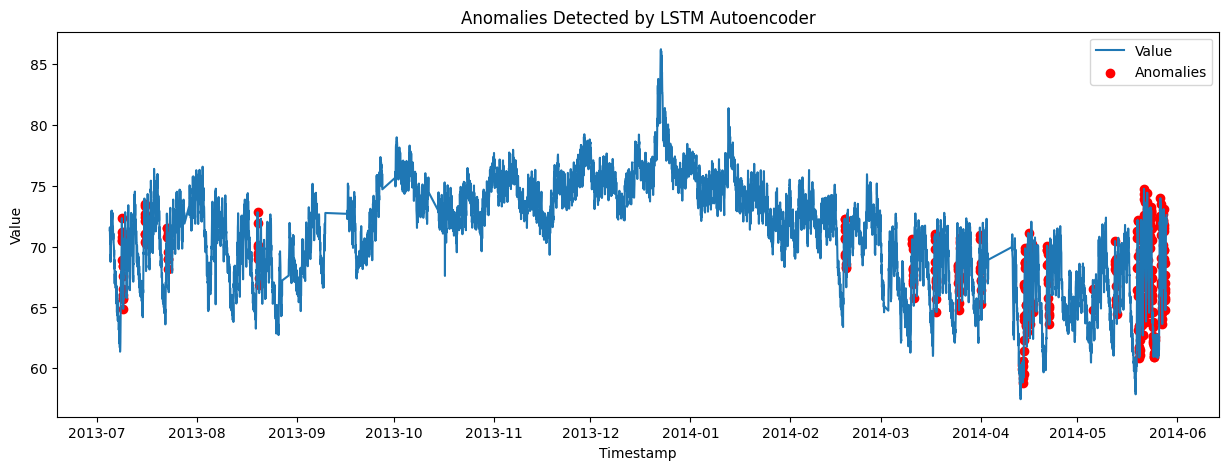

In [17]:
plot_anomalies(df_anomaly, 'lstm_anomaly', 'Anomalies Detected by LSTM Autoencoder')


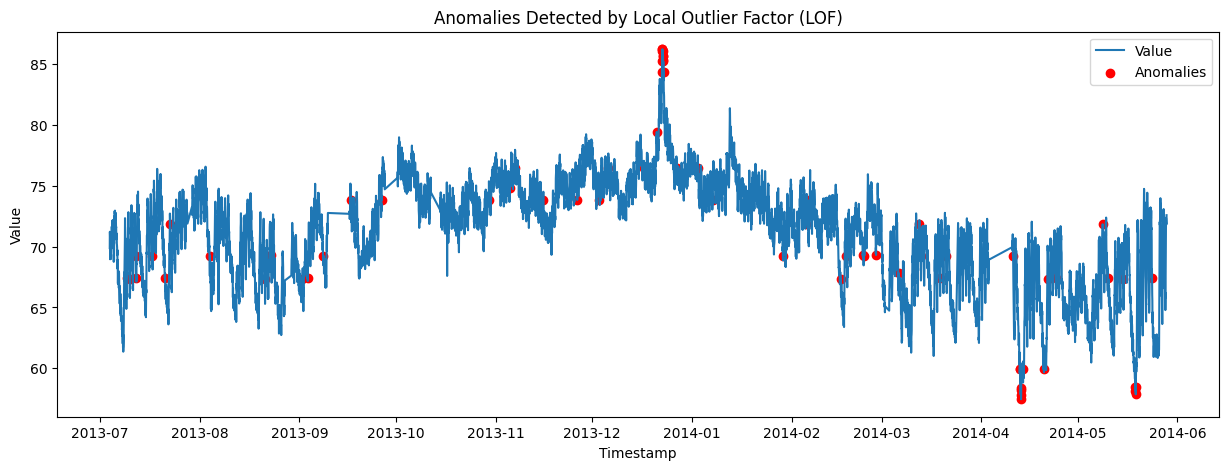

In [18]:
plot_anomalies(df, 'lof_anomaly', 'Anomalies Detected by Local Outlier Factor (LOF)')


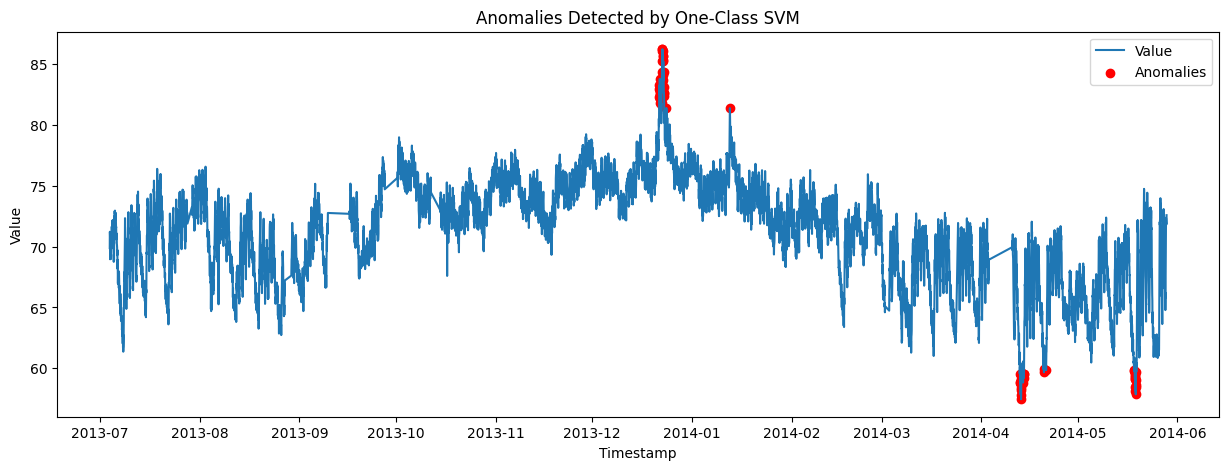

In [19]:
plot_anomalies(df, 'ocsvm_anomaly', 'Anomalies Detected by One-Class SVM')
